In [1]:
# Basic imports
import os
import itertools
from collections import deque

# Imports for gym and gym retro features
from gym import Env
import gym
from gym.spaces import Box, Discrete
import retro
from retro import RetroEnv
from gym.utils.play import play

# To help with image preprocessing
import numpy as np
import cv2

# To help with learning by imitation (Imitation library)
from imitation.data.types import save, load, TransitionsMinimal, Trajectory

pygame 2.1.2 (SDL 2.0.18, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Collection of expert demos

In order to transfer learning from expert demos (a human in this case), we first need to obtain these demos, also known as "trajectories" in the associated literature. The implementation of a "wrapper" that allows us to introduce our actions to a Gym Retro environment can be found in the following repository within the retro library:

https://github.com/openai/retro/blob/master/retro/examples/interactive.py

We will use this __"wrapper"__, which itself is not an SB3 "Wrapper" class, but a specific unique class.

However, it is necessary to make some modifications to it, because this "wrapper" does not allow us to extract the observations, actions, and rewards from the RetroEnv object.

In this notebook we are going to explore all the necessary activities needed to be able to collect the trajectories, clean them, convert them to a data type compatible with the "Imitation" library, and be able to use them in the transfer of learning by imitation in an SB3 PPO agent.

In [2]:
"""
Interact with Gym environments using the keyboard
An adapter object is defined for each environment to map keyboard commands to actions and extract 
observations as pixels.
"""

import sys
import ctypes
import abc
import time

import numpy as np
import retro
import pyglet
from pyglet import gl
from pyglet.window import key as keycodes


class Interactive(abc.ABC):
    """
    Base class for making gym environments interactive for human use
    """
    def __init__(self, env, sync=True, tps=60, aspect_ratio=None, episodes_to_play=1):
        obs = env.reset()
        self._image = self.get_image(obs, env)
        assert len(self._image.shape) == 3 and self._image.shape[2] == 3, 'must be an RGB image'
        image_height, image_width = self._image.shape[:2]
        self.trajectory = []
        self._run_done = False
        self._run_info = []
        self._run_reward = 0
        self.pressed_keys = None
        self._keys = None
        self.episodes_to_play = episodes_to_play
        self.expert_demos = []
        
        self.traj_obs = []
        self.traj_actions = []
        self.traj_infos = []
        self.traj_dones = []
        self.traj_rewards = []

        if aspect_ratio is None:
            aspect_ratio = image_width / image_height

        # guess a screen size that doesn't distort the image too much but also is not tiny or huge
        display = pyglet.canvas.get_display()
        screen = display.get_default_screen()
        max_win_width = screen.width * 0.9
        max_win_height = screen.height * 0.9
        win_width = image_width
        win_height = int(win_width / aspect_ratio)

        while win_width > max_win_width or win_height > max_win_height:
            win_width //= 2
            win_height //= 2
        while win_width < max_win_width / 2 and win_height < max_win_height / 2:
            win_width *= 2
            win_height *= 2

        win = pyglet.window.Window(width=win_width, height=win_height)

        self._key_handler = pyglet.window.key.KeyStateHandler()
        win.push_handlers(self._key_handler)
        win.on_close = self._on_close

        gl.glEnable(gl.GL_TEXTURE_2D)
        self._texture_id = gl.GLuint(0)
        gl.glGenTextures(1, ctypes.byref(self._texture_id))
        gl.glBindTexture(gl.GL_TEXTURE_2D, self._texture_id)
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_WRAP_S, gl.GL_CLAMP)
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_WRAP_T, gl.GL_CLAMP)
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MAG_FILTER, gl.GL_NEAREST)
        gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MIN_FILTER, gl.GL_NEAREST)
        gl.glTexImage2D(gl.GL_TEXTURE_2D, 0, gl.GL_RGBA8, image_width, image_height, 0, gl.GL_RGB, gl.GL_UNSIGNED_BYTE, None)

        self._env = env
        self._win = win

        # self._render_human = render_human
        self._key_previous_states = {}

        self._steps = 0
        self._episode_steps = 0
        self._episode_returns = 0
        self._prev_episode_returns = 0

        self._tps = tps
        self._sync = sync
        self._current_time = 0
        self._sim_time = 0
        self._max_sim_frames_per_update = 4

    def _update(self, dt):
        # cap the number of frames rendered so we don't just spend forever trying to catch up on frames
        # if rendering is slow
        max_dt = self._max_sim_frames_per_update / self._tps
        if dt > max_dt:
            dt = max_dt

        # catch up the simulation to the current time
        self._current_time += dt
        while self._sim_time < self._current_time:
            self._sim_time += 1 / self._tps

            keys_clicked = set()
            keys_pressed = set()
            for key_code, pressed in self._key_handler.items():
                if pressed:
                    keys_pressed.add(key_code)
                if not self._key_previous_states.get(key_code, False) and pressed:
                    keys_clicked.add(key_code)
                self._key_previous_states[key_code] = pressed

            if keycodes.ESCAPE in keys_pressed:
                self._on_close()

            # assume that for async environments, we just want to repeat keys for as long as they are held
            inputs = keys_pressed
            if self._sync:
                inputs = keys_clicked

            keys = []
            for keycode in inputs:
                for name in dir(keycodes):
                    if getattr(keycodes, name) == keycode:
                        keys.append(name)

            act = self.keys_to_act(keys)
            self.pressed_keys = act
            self._keys =  keys

            if not self._sync or act is not None:
                obs, rew, done, _info = self._env.step(act)
                self._run_done = done      
                self._run_info = _info
                self._run_reward = rew
                self._image = self.get_image(obs, self._env)
                self._episode_returns += rew
                self._steps += 1
                self._episode_steps += 1
                np.set_printoptions(precision=2)
                
                act = self.keys_to_act(keys)
                self.pressed_keys = act
                self._keys =  keys
                
                if self._sync:
                    done_int = done  # shorter than printing True/False
#                     done_int = int(done)  # shorter than printing True/False
                    mess = 'steps={self._steps} episode_steps={self._episode_steps} rew={rew} episode_returns={self._episode_returns} done={done_int}'.format(
                        **locals()
                    )
                    print(mess)
            
                elif self._steps % self._tps == 0 or done:
                    episode_returns_delta = self._episode_returns - self._prev_episode_returns
                    self._prev_episode_returns = self._episode_returns
                    mess = 'steps={self._steps} episode_steps={self._episode_steps} episode_returns_delta={episode_returns_delta} episode_returns={self._episode_returns}'.format(
                        **locals()
                    )
                    print(mess)
                if done:
#                     self._env.close()
                    self._env.reset()
                    self._episode_steps = 0
                    self._episode_returns = 0
                    self._prev_episode_returns = 0
                
                    self._run_reward = 0

    def _draw(self):
        gl.glBindTexture(gl.GL_TEXTURE_2D, self._texture_id)
        video_buffer = ctypes.cast(self._image.tobytes(), ctypes.POINTER(ctypes.c_short))
        gl.glTexSubImage2D(gl.GL_TEXTURE_2D, 0, 0, 0, self._image.shape[1], self._image.shape[0], gl.GL_RGB, gl.GL_UNSIGNED_BYTE, video_buffer)

        x = 0
        y = 0
        w = self._win.width
        h = self._win.height

        pyglet.graphics.draw(
            4,
            pyglet.gl.GL_QUADS,
            ('v2f', [x, y, x + w, y, x + w, y + h, x, y + h]),
            ('t2f', [0, 1, 1, 1, 1, 0, 0, 0]),
        )

    def _on_close(self):
        self._env.close()
#         sys.exit(0)

    @abc.abstractmethod
    def get_image(self, obs, venv):
        """
        Given an observation and the Env object, return an rgb array to display to the user
        """
        pass

    @abc.abstractmethod
    def keys_to_act(self, keys):
        """
        Given a list of keys that the user has input, produce a gym action to pass to the environment
        For sync environments, keys is a list of keys that have been pressed since the last step
        For async environments, keys is a list of keys currently held down
        """
        pass
    

    def run(self):
        """
        Run the interactive window until the user quits
        """
        # pyglet.app.run() has issues like https://bitbucket.org/pyglet/pyglet/issues/199/attempting-to-resize-or-close-pyglet
        # and also involves inverting your code to run inside the pyglet framework
        # avoid both by using a while loop
        prev_frame_time = time.time()
        for _ in range(self.episodes_to_play):
            # The following line of code is important, it resets a temporary buffer that if not reset
            # causes program execution to terminate unexpectedly (mainly because of a
            # misalignment in accessing game memory locations)
            prev_frame_time = time.time()
            while not self._run_done:
                self._win.switch_to()
                self._win.dispatch_events()
                now = time.time()
                self._update(now - prev_frame_time)
                prev_frame_time = now
                self._draw()
                self._win.flip()
                
                # Add the agent variables to each list of variables
                self.traj_obs.append(self._image)
                self.traj_actions.append(self.pressed_keys)
                self.traj_infos.append(self._run_info)
                self.traj_dones.append(self._run_done)
                self.traj_rewards.append(self._run_reward)
                # Add all variables to the current step
                # To accumulate samples in a trajectory
                self.trajectory.append([self._image,
                                        self.pressed_keys,
                                        self._run_info,
                                        self._run_done,
                                        self._run_reward]
                                      )
                
            self.expert_demos.append(self.trajectory)
            
            # We reset each variable for the start of a new episode
            self._run_done = False
            self.trajectory = []
            self.traj_obs = []
            self.traj_actions = []
            self.traj_infos = []
            self.traj_dones = []
            self.traj_rewards = []
            
        # When finishing all the episodes, we close the emulator
        self._on_close()
    
    
    def get_expert_demos(self):
        return self.expert_demos

    


class RetroInteractive(Interactive):
    """
    Interactive setup for retro games
    """
    def __init__(self, game, state, scenario, record, episodes_to_play):
        env = retro.make(game=game,
                         state=state,
                         scenario=scenario,
                         record=record,
                         inttype=retro.data.Integrations.STABLE
                        )
        self._buttons = env.buttons
        self.episodes_to_play = episodes_to_play
        super().__init__(env=env,
                                              sync=False,
                                              tps=60,
                                              aspect_ratio=4/3,
                                              episodes_to_play=self.episodes_to_play
                                             )

    def get_buttons(self):
        """
        Allows me to get the buttons
        """
        return self._buttons
        
    def get_image(self, _obs, env):
        return env.render(mode='rgb_array')
    
    def get_action_meaning(self, action):
        return env.get_action_meaning(action)

    def keys_to_act(self, keys):
        inputs = {
            None: False,

            'BUTTON': 'Z' in keys,
            'A': 'Z' in keys,
            'B': 'X' in keys,

            'C': 'C' in keys,
            'X': 'A' in keys,
            'Y': 'S' in keys,
            'Z': 'D' in keys,

            'L': 'Q' in keys,
            'R': 'W' in keys,

            'UP': 'UP' in keys,
            'DOWN': 'DOWN' in keys,
            'LEFT': 'LEFT' in keys,
            'RIGHT': 'RIGHT' in keys,

            'MODE': 'TAB' in keys,
            'SELECT': 'TAB' in keys,
            'RESET': 'ENTER' in keys,
            'START': 'ENTER' in keys,
        }
        return [inputs[b] for b in self._buttons]
    


## Collection of expert demos (expert demos)

This operation must be performed by a human, and cannot be automated, so whenever we want to collect the expert trajectories, we have to come here and "play" the game.

To start with the collection we just execute the "run()" method of the __"RetroInteractive"__ class created above, and then we start playing:

In [3]:
from imitation.data.buffer import ReplayBuffer

GAME = 'Mtpo-Nes'
GAME_STATE = 'KingHippo.state'
SCENARIO = 'scenario_king_hippo'
EPISODES = 2

env = RetroInteractive(game=GAME,
                      state=GAME_STATE,
                      scenario=SCENARIO,
                      episodes_to_play=EPISODES,
                      record='.'
                     )

Sometimes, the enviroment "breaks" in the middle of an episode, if this happens, just save the trajectories collected so far, and repeat until you have collected all the trajectories you need:

In [4]:
env.run()

steps=60 episode_steps=60 episode_returns_delta=0.0 episode_returns=0.0
steps=120 episode_steps=120 episode_returns_delta=0.0 episode_returns=0.0
steps=180 episode_steps=180 episode_returns_delta=-5.0 episode_returns=-5.0
steps=240 episode_steps=240 episode_returns_delta=0.0 episode_returns=-5.0
steps=300 episode_steps=300 episode_returns_delta=0.0 episode_returns=-5.0
steps=360 episode_steps=360 episode_returns_delta=0.0 episode_returns=-5.0
steps=420 episode_steps=420 episode_returns_delta=-5.0 episode_returns=-10.0
steps=480 episode_steps=480 episode_returns_delta=0.0 episode_returns=-10.0
steps=540 episode_steps=540 episode_returns_delta=0.0 episode_returns=-10.0
steps=600 episode_steps=600 episode_returns_delta=0.0 episode_returns=-10.0
steps=660 episode_steps=660 episode_returns_delta=-5.0 episode_returns=-15.0
steps=720 episode_steps=720 episode_returns_delta=0.0 episode_returns=-15.0
steps=780 episode_steps=780 episode_returns_delta=0.0 episode_returns=-15.0
steps=840 episode_s

In [ ]:
env._on_close()

Now lets create a function that preprocess the images from the trajectories to transform them the same as the images from the "Env" object:

In [50]:
def preprocess(observation):
        """ 
        Method to preprocess the images that the "Env" object uses during training.
         The idea is to deliver a reduced observation, which helps streamline the training processes of the
         agent. The derivation of the reduced observation can be seen in the notebook:
        
         - "1_CV_Preprocessing.ipynb"
        
         which is part of this "Notebooks" section
        """
        # Cropping
        xlen = observation.shape[0]
        ylen = observation.shape[1]
        focus_zone = observation[int(xlen*(1/8)):int(xlen*(3/2)),int(ylen/3):-int(ylen/3)]
        # Grayscale
        gray = cv2.cvtColor(focus_zone, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        
        # We must fit the output to a tensor with three dimensions, since it
        # is the data structure that the gym object expects.
        channels = np.reshape(resize, (1,84,84))

        return channels

def extract_trajectories_from_data(data, num_frames_to_stack):
    """
    Function that takes the paths (as lists) grouped in the form of lists, with the form
    
     expert_paths = [t1, t2, t3, ... tN]
    
     and extracts them. Each trajectory is a list that has the form:
    
     trajectory(i) = [[observation(i), action(i), info(i), done(i), reward(i)], ... [observation(N), action(N), info(N) ), done(N), reward(N)]]
    
     where N is the length of the path(i).
    
     and generate new lists:
    
         * observations = [o1, o2, o3 ... oN]
         * actions = [a1, a2, a3, ... aN]
         * infos = [info1, info2, info3, ... infoN]
         * gifts = [d1, d2, d3, ... dN]
    
     These lists will then be the input to a function from the 'Imitation' library that
     generates the 'TrajectoryWithRewards' objects that we can use in the algorithms
     from IL
    """
    
    # Define a dictionary to translate the Multibinary inputs, to Discrete inputs
    # As needed to the IRL agent.
    diccionario_combos = {
        18 : [False,False,False,False,False,False,False,False,True], # ['A'] Right
        6 : [False,False,False,False,False,False,False,True,False], # ['RIGHT'] Right Dodge
        3 : [False,False,False,False,False,False,True,False,False], # ['LEFT'] Left Dodge
        0 : [False,False,False,False,False,False,False,False,False], # [] No action
        9 : [True,False,False,False,False,False,False,False,False], # ['B'] Left swipe
        19 : [False,False,False,False,True,False,False,False,True], # ['UP','A'] Right Uppercut
        10 : [True,False,False,False,False,False,False,False,False]# ['UP','B'] Left Uppercut
    }

    
    length = len(data)
    single_obs_dim = data[0][0].shape
    action_space_length = 24
    
    # Define the observations array to store all the trajectories observations
    # Add one additional observation, because it is needed by the Trajectory object.
    
    # It is also important to emphasasize that because of the vec transpose image wrapper
    # we need to have the observations with the following shape = (1, 84, 84 * stacked_frames)
    observations = np.zeros(shape=(length + 1,)+(1, 84, 84*num_frames_to_stack),
                           dtype=Box(low=0, high=255, shape=(1, 84, 84*num_frames_to_stack), dtype=np.uint8)
                           )
    
    # Define the actions array to store all the actions
    actions = np.zeros(shape=(length,),
                       dtype=Discrete(action_space_length))
    
    # List to save all the "info" variables from the trajectories
    infos = []
    rewards = np.zeros(shape=(length,))
    # It is needed to simulate the frame stacking from the "Env" object.
    stacked_frames = deque(maxlen=num_frames_to_stack)
    
    # Iterate through the trajectories, extracting each set of data needed
    # following the order explained in the method's docstring.
    for trajectory, n in zip(data, range(length)):
        # For observations
        processed_obs = preprocess(trajectory[0])
        stacked_frames.append(processed_obs)

        if len(stacked_frames) == num_frames_to_stack:
            stacked_obs = np.array(list(stacked_frames), dtype=np.uint8)
            stacked_obs = stacked_obs.reshape((1, 84, 84*num_frames_to_stack))
        else:
            for _ in range(num_frames_to_stack - len(stacked_frames)):
                stacked_frames.append(np.zeros(shape=(1,84,84), dtype=np.uint8))
            stacked_obs = np.array(list(stacked_frames), dtype=np.uint8)
            stacked_obs = stacked_obs.reshape((1, 84, 84*num_frames_to_stack))
        observations[n] = stacked_obs
        # For the actions
        for key, value in diccionario_combos.items():
            if trajectory[1] == value:
                actions[n] = key
        # For the 'infos'
        infos.append(trajectory[2])
    
    return observations, actions, infos

## Conversion of trajectories from data type 'lists', to data type 'Trajectory' from the 'Imitation' library

Some of the models and algorithms in the reverse learning "Imitation" library need __"expert demos"__, or trajectories, in order to work, however, these expert proofs must have a certain data structure, so it is necessary perform a conversion, from traditional lists (the way data is collected) to these special data structures.

To perform this task, the "Imitation" library has a helper object type, called __"Trajectory"__. This object type takes the trajectories we have collected, and transforms them into data structures with the same name, which can be seamlessly used in IRL models and algorithms.

In [51]:
expert_demos = env.get_expert_demos()

In [52]:
len(expert_demos)

2

In [53]:
expert_trajectories = []
STACKED_FRAMES = 12

for trajectory in expert_demos:
    observations, actions, infos  = extract_trajectories_from_data(trajectory,
                                   STACKED_FRAMES
                                  )
    observations[0] = np.zeros(shape=(1,84,84*STACKED_FRAMES), dtype=np.uint8)
    demo = Trajectory(observations, actions, infos, True)
    expert_trajectories.append(demo)

### Now lets make some checking:

In [54]:
len(expert_trajectories)

2

In [55]:
expert_trajectories[0].obs[0].shape

(1, 84, 1008)

In [56]:
expert_trajectories[0].obs[1].shape

(1, 84, 1008)

In [57]:
expert_trajectories[0].obs[1].shape[-1]

1008

In [58]:
expert_trajectories[0].acts.shape

(2436,)

In [59]:
[accion for accion in expert_trajectories[0].acts][-20:]

[18, 18, 18, 18, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
expert_trajectories[0].acts[1]

0

In [61]:
expert_trajectories[0].acts[11].dtype

dtype('int64')

In [62]:
type(expert_trajectories[0])

imitation.data.types.Trajectory

All checks should align with what is expected.

## We plot an observation

To give a sensation of movement to the agent, we perform a stacking operation of __12__ "frames".

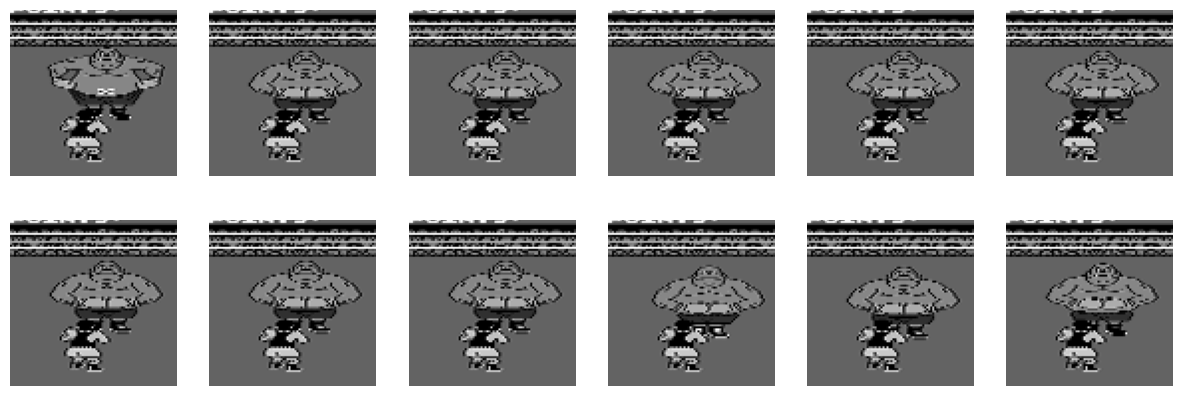

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
env_screen = expert_trajectories[0].obs[1220]
env_screen = env_screen.reshape((STACKED_FRAMES,84,84,1))
fig, axes = plt.subplots(2,int(STACKED_FRAMES/2), figsize=(15,5))
for n, axe in zip(range(STACKED_FRAMES), axes.flatten()):
    axe.imshow(env_screen[n,:,:],
               cmap='gray'
              )
    axe.axis('off')
plt.show()

# If it is the first time collecting the trajectories
You must first save a set of trajectories (three cells below). From the second time on, you can follow the order in which the notebook comes.

## We load the previous trajectories

In [64]:
# file_name = 'Expert_demos_reduced_obs_stacked_2-episodes.npz'
# path = os.path.join('..', 'expert_demos')
# file_path = os.path.join(path, file_name)

# os.makedirs(path, exist_ok=True)

# saved_expert_trajectories = load(file_path)

## We accumulate the trajectories by putting them all together

In [66]:
# total_expert_trajectories = saved_expert_trajectories

In [8]:
len(total_expert_trajectories)

20

## We save the trajectories created:

In [67]:
# q_episodes= len(saved_expert_trajectories)
q_episodes = len(expert_trajectories)
file_name = 'Expert_demos_reduced_obs_stacked_{}-episodes.npz'.format(q_episodes)
save_path = os.path.join('..', 'expert_demos')
os.makedirs(save_path, exist_ok=True)

path_archivo = os.path.join(save_path, file_name)
save(path_archivo, expert_trajectories)
# save(path_archivo, total_expert_trajectories)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Las cargamos de nuevo para verificar:

In [68]:
file_name = 'Expert_demos_reduced_obs_stacked_{}-episodes.npz'.format(q_episodes)
save_path = os.path.join('..', 'expert_demos', file_name)

In [69]:
loaded_expert_trajectories = load(save_path)

## And we plot them again to confirm that they were saved and loaded correctly:

In [70]:
STACKED_FRAMES = 12

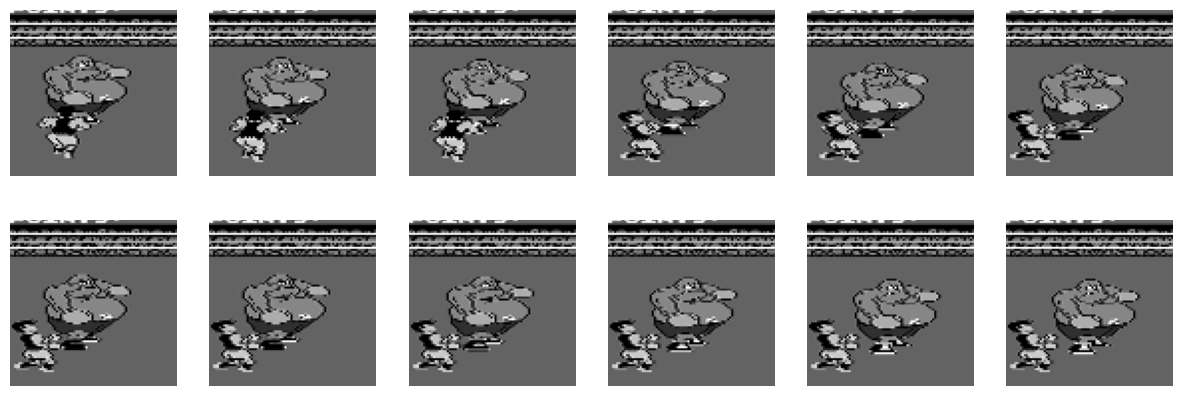

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
env_screen = loaded_expert_trajectories[1].obs[1225]
env_screen = env_screen.reshape((STACKED_FRAMES,84,84,1))
fig, axes = plt.subplots(2,int(STACKED_FRAMES/2), figsize=(15,5))
for n, axe in zip(range(STACKED_FRAMES), axes.flatten()):
    axe.imshow(env_screen[n,:,:],
               cmap='gray'
              )
    axe.axis('off')
plt.show()

And save the trajectories: